# Converting Shape Geoms to Raster Image
---

## Setup Notebook
---

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [31]:
import fiona
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio import features
from rasterio.enums import MergeAlg
from rasterio.plot import show
import numpy as np
from shapely.geometry import Polygon, MultiPolygon, shape, Point

from osgeo import gdal
from osgeo import ogr

## Load Data
---

In [36]:
# Load Data
raster = '/workspace/data-sets/Land_Cover/nyc-lc-2-2.tif'
shape = '/workspace/data-sets/NYC_DoITT_Planimetric_OpenData.gdb/NYC_DoITT_Planimetric_OpenData.gdb'

In [37]:
# Load Vector Data
layer_list = fiona.listlayers(shape)
plan_data_list = []

for layer_name in layer_list:
    plan_data_list.append(gpd.read_file(shape, layer=layer_name))
    
# Load Raster data

In [52]:
raster = gdal.Open("/workspace/data-sets/Land_Cover/nyc-lc-2-2.tif")

## Rasterize Point Values
---

In [39]:
## Extract Z Values and convert geo to point
# load data from geo data base
vector = plan_data_list[14]

# Extract Z Values
x_list = []
y_list = []
z_list = []
for feature in vector.geometry:
    coords = list(feature.coords)
    x_list.append(coords[0][0])
    y_list.append(coords[0][1])
    z_list.append(coords[0][2])

# Append Z values to dataframe
vector['x'] = x_list
vector['y'] = y_list
vector['z'] = z_list

vector['geometry'] = gpd.points_from_xy(vector.x, vector.y, crs=vector.crs)
vector.head()

,ELEVATION,SOURCE_ID,FEATURE_CODE,SUB_FEATURE_CODE,STATUS,geometry,x,y,z
0,129.740000,2.130200e+10,3020,302000,Unchanged,POINT (989083.000 195003.260),989082.999837,195003.259978,129.7400
1,120.586263,2.130000e+10,3000,300020,Unchanged,POINT (987638.301 195007.228),987638.300954,195007.227818,120.5863
2,114.740000,2.130200e+10,3020,302000,Unchanged,POINT (988565.410 195011.600),988565.409993,195011.599856,114.7400
3,69.130000,2.130200e+10,3020,302000,Unchanged,POINT (989509.570 195013.270),989509.569850,195013.270128,69.1300
4,49.235397,2.130200e+10,3020,302000,Unchanged,POINT (987570.796 195019.969),987570.795840,195019.969262,49.2354


In [46]:
# Save modified gpd (This is needed to create a shape file from the gdb
# Note you can only have one geometry in the gdf to save it

# vector.to_file(driver = 'ESRI Shapefile', filename= "test.shp")

In [57]:
# # Extract Features from Base Raster
ulx, xres, xskew, uly, yskew, yres  = raster.GetGeoTransform()
lrx = ulx + (raster.RasterXSize * xres)
lry = uly + (raster.RasterYSize * yres)
width = raster.RasterXSize
height = raster.RasterYSize

# left= bounds.left
# right = bounds.right
# bottom = bounds.bottom
# top = bounds.top
# width,height=raster.RasterXSize, raster.RasterYSize

In [ ]:
nn = gdal.Grid("nn-test.tif", 
               'test.shp', 
               zfield='z', 
               algorithm='nearest',
               outputBounds=[ulx,uly,lrx,lry],
               width=width,
               height=height)

In [ ]:
nn = None

In [ ]:
ts = gdal.Open("nn-test.tif")
band = ts.GetRasterBand(1)
arr = band.ReadAsArray()
plt.imshow(arr)

In [45]:
ts.crs

AttributeError: 'Dataset' object has no attribute 'crs'

First we'll start by extracting z-value features as shown in the 02 notebook.

In [ ]:
# def convert_3D_2D(geometry):
# #     '''
# #     Takes a GeoSeries of 3D Multi/Polygons (has_z) and returns a list of 2D Multi/Polygons
# #     '''
# #     new_geo = []
# #     for p in geometry:
# #         if p.has_z:
# #             if p.geom_type == 'Polygon':
# #                 lines = [xy[:2] for xy in list(p.exterior.coords)]
# #                 new_p = Polygon(lines)
# #                 new_geo.append(new_p)
# #             elif p.geom_type == 'MultiPolygon':
# #                 new_multi_p = []
# #                 for ap in p:
# #                     lines = [xy[:2] for xy in list(ap.exterior.coords)]
# #                     new_p = Polygon(lines)
# #                     new_multi_p.append(new_p)
# #                 new_geo.append(MultiPolygon(new_multi_p))
# #     return new_geo

# # # geodf_2d = gp.GeoDataFrame.from_file(vector) # plug_in your shapefile
# # # geodf_2d.geometry = convert_3D_2D(geodf_2d.geometry) # new geodf with 2D geometry series
# # test = convert_3D_2D(vector.geometry) # new geodf with 2D geometry series

In [17]:
test

[]

### Rasterize Points

In [28]:
# geom_value = ((geom,value) for geom, value in zip(vector.geometry, vector['z-values']))
geom = [shapes for shapes in vector.geometry]

In [29]:
rasterized = features.rasterize(geom,
                                out_shape = raster.shape,
                                fill = 0,
                                out = None,
                                transform = raster.transform,
                                all_touched = False,
                                default_value = 1,
                                dtype = None)

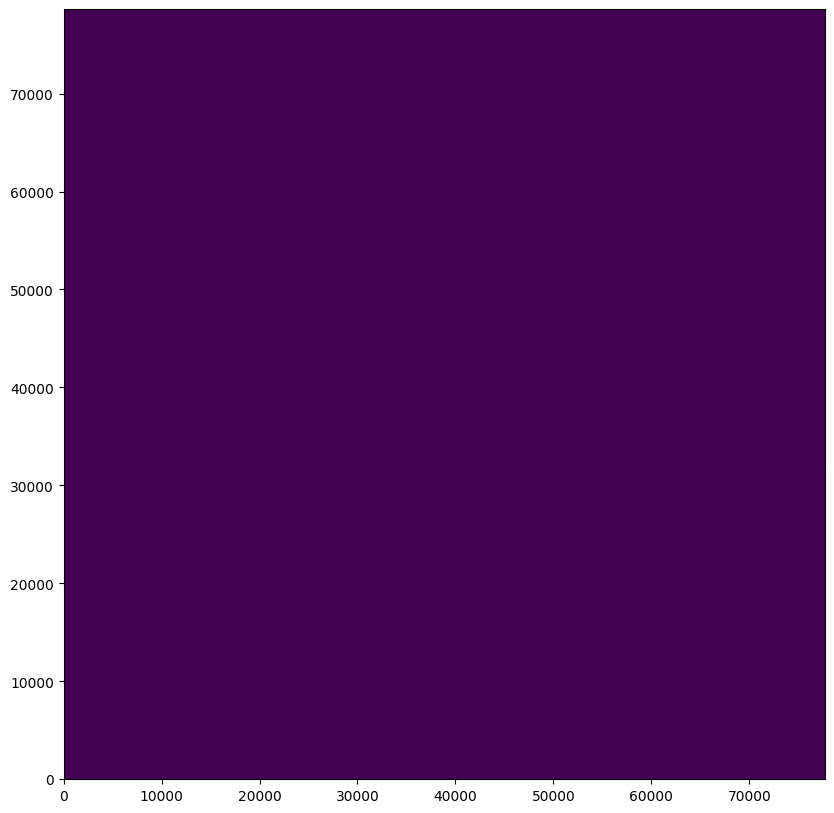

In [30]:
# Plot raster
fig, ax = plt.subplots(1, figsize = (10, 10))
show(rasterized, ax = ax)
plt.gca().invert_yaxis()

In [ ]:
#Write Raster to File 
with rasterio.open(
        "../temp/rasterized_vector.tif", "w",
        driver = "GTiff",
        transform = raster.transform,
        dtype = rasterio.uint8,
        count = 1,
        width = raster.width,
        height = raster.height) as dst:
    dst.write(rasterized, indexes = 1)

In [ ]:
https://gis.stackexchange.com/questions/136059/convert-vector-point-shape-to-raster-tif-using-python-gdal-lib-in-qgis
https://gis.stackexchange.com/questions/308002/how-can-i-convert-shapefile-to-raster-and-mask-using-gdal-python-3
https://pygis.io/docs/e_raster_rasterize.html

## Rasterize Line Values
---

## Rasterize Poly Values
---

In [ ]:
https://gdal.org/programs/gdal_rasterize.html